##### nsbh-remnant.ipynb

### *remnant matter contour plot from Foucart+ 2018 fit to NSBH merger simulations compared against estimated compact binary merger parameters*

this notebook plots contours of constant remnant mass (as a fraction of the neutron star baryonic mass) as a function of black hole spin in neutron star--black hole mergers according to the empirical formula from Foucart+ 2018, based on a suite of neutron star--black hole merger simulations, and overlays the estimated masses for a given candidate compact binary merger event

##### philippe landry (pgjlandry@gmail.com) 04/2024

In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
import src.fhn18 as fhn
from src.plot import *

plt.rcParams["text.usetex"] = False
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16

In [2]:
# user input

F_threshold = 0.01

RNS = 12. # simulation values of the compactness range from 0.13 to 0.18
chiBHs = [-0.4,0.,0.4,0.6,0.8] # simulation values range from -0.5 to 0.97

q_range = (0.143,1.) # simulation values of the mass ratio range from 0.143 to 1.
C_range = (0.13,0.19) # simulation values of the compactness range from 0.13 to 0.182

mNS_range = ((1e5*c**2*RNS)/(G*Msol))*np.array(C_range) 
mBH_range = (mNS_range[1]/q_range[1],mNS_range[1]/q_range[0])

mNSgrid = (0.5,2.5)
mBHgrid = (2.5,10.5)

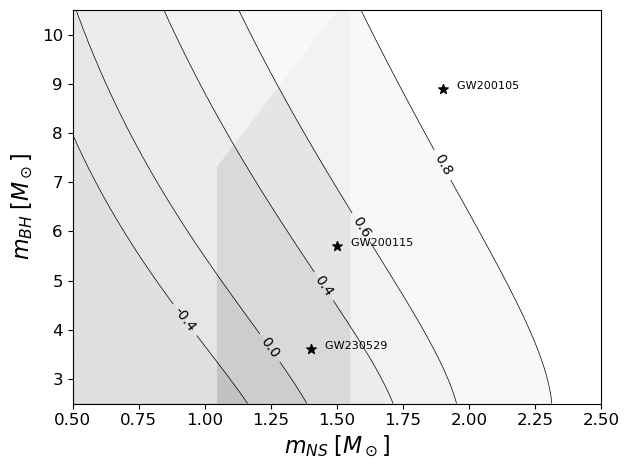

In [24]:
# make contour plot

plt.figure()

remnant_mass_contour_plot(mBHgrid,mNSgrid,chiBHs,RNS,F_threshold,mBHrange=mBH_range,mNSrange=mNS_range,qrange=q_range,model=fhn.F_remnant)

plt.scatter(1.9,8.9,marker='*',s=50,c='k',zorder=1)
plt.annotate('    GW200105',(1.9,8.9),fontsize=8)

plt.scatter(1.5,5.7,marker='*',s=50,c='k',label='GW200115',zorder=1)
plt.annotate('    GW200115',(1.5,5.7),fontsize=8)

plt.scatter(1.4,3.6,marker='*',s=50,c='k',label='GW230529',zorder=1)
plt.annotate('    GW230529',(1.4,3.6),fontsize=8)

plt.tight_layout()
plt.show()